# MI-PAA, Úloha 5: Řešení problému vážené splnitelnosti booleovské formule pokročilou iterativní metodou

**Marián Hlaváč**, 12 Jan 2017 (hlavam30)  
marian.hlavac@fit.cvut.cz  
https://github.com/mmajko/sat3-problem

## Zadání 

Problém řešte některou z pokročilých lokálních heuristik (simulované ochlazování, genetické algoritmy, tabu prohledávání). Řešení jinými metodami prosím zkonzultovat se cvičícím nebo přednášejícím. Volby konkrétních parametrů heuristiky a jejích detailů (operace nad stavovým prostorem, kritérium ukončení, atd. atd.) proveďte sami, tyto volby pokud možno zdůvodněte a ověřte experimentálním vyhodnocením.

V práci bude uvažována varianta 3SAT.

## Přehled postupu řešení

Podle minulé úlohy volím jako lokální heuristiku **genetický algoritmus**. Algoritmus jsem v minulé úloze napsal jako znovupoužitelný kód a je tak snadné vyměnit problém, který bude řešit. O vlastnostech algoritmu se zmiňuji v sekci [Znovupoužitelný kód z minulé úlohy](#Znovupoužitelný-kód-z-minulé-úlohy).

Řešit celou pátou úlohu jsem se rozhodl systematicky ve čtyřech krocích: Znovupoužít kód pro GA z minulé úlohy, následně dopsat podpůrné metody a struktury pro řešení SAT problému, ve třetím kroku napsaný kód spustím a odhalím chyby a neúspěch a v posledním kroku se pokusím do co největší míry neúspěchů zbavit a postupně se dopracovat k co nejlepšímu výsledku. A na závěr samozřejmě prezentovat výsledky v podobě této zprávy.

## Řešení

Algoritmus a celý program poskytující výsledky je napsán v jazyce Rust. Tento program načte instance z předpřipravených datových souborů určených pro tuto úlohu a vypočte řešení. Zapíše výsledky a délky provádění výpočtů a všechna data poskytne v CSV formátu.

Druhým nástrojem je pak Jupyter Notebook, ve kterém se poskytnutá data zpracují a vizualizují.

### Algoritmus a zdrojový kód

Kompletně celý algoritmus je k nahlédnutí ve zdrojových souborech programu, které lze nalézt na GitHub stránce úlohy. Odkaz na repozitář je uveden v hlavičce zprávy.

Projekt lze zkompilovat a spustit pomocí instrukcí uvedených v souboru `README.md` ve zmíněném repozitáři.

### Čtení DIMACS formátu

Jako první část úlohy jsem napsal kód pro načítání vstupu. Rozhodl jsem se načítat DIMACS formát, abych mohl spouštět DIMACS instance. DIMACS formát je však pro tuto úlohu nedostačující a bylo nutné si jej doupravit.

#### Rozšíření DIMACS na vlastní "WDIMACS"

Rozšířil jsem formát DIMACS na vlastní "weighted-DIMACS" formát, který umožňuje do souboru přiložit informaci o vahách proměnných.

Za prefix `w` jsou pak mezerou oddělené uvedené váhy v pořadí jednotlivých proměnných. Takový soubor pak může vypadat nějak takhle:

```
c Weighted CNF
p cnf 4 6
w 2 4 1 6
1 -3 4 0
-1 2 -3 0
...
```

### Znovupoužitelný kód z minulé úlohy

Z minulé úlohy jsem použil kód řešící evoluční algoritmus. Tento evoluční algoritmus má následující vlastnosti (implementuje techniky):

- Uniformní křízení
- Turnajová selekce
- Elitismus
- Mutace za pomocí náhodné inverze
- Discarding (nevyhovující individua jsou zahazováky)

V kódu minulé úlohy jsem také výhodně využil closures jazyka Rust. Funkce pro spuštění simulace evoluce tak prakticky přijímá pouze tři argumenty. Prvním z nich je struktura s konfigurací evoluce, obsahující kolik proběhne generací, jaké jsou pravděpodobnosti apod., druhým argumentem je funkce, která pro vstup bitového pole vrátí číslo reprezentující zdatnost (fitness funkce) a třetím argumentem je funkce omezující podmínky.

Díky této struktuře kódu bylo snadné velmi rychle se přesunout od řešení problému batohu k řešení problému SAT. Algoritmus však přecijen potřeboval určité funkce doladit.

Ukázka kódu, který má na starosti spuštění samotné simulace evoluce (zkrácen):

```rust
pub fn solve(problem: &Problem, sol_id: usize) -> Solution {
    ...
    // Define a fitness function
    let fitness_fn = |x: &Vec<bool>| {
        let satisfied = count_satisfied(x, &problem.formula) as f32;
        let weight_sum = sum_valid_weights(x, &problem.weights) as f32;

        let fitness = 10000.0 * (k * (satisfied / clausules).exp() ...
        fitness as usize
    };
    
    // Define a constraint function (used only for validation)
    let constraint_fn = |x: &Vec<bool>| { count_satisfied(x, &problem.formula) == problem.clausules as usize };

    // Configure the evolution
    let configuration = genetic::EvolutionConfiguration {
        pop_size: 32, // Population size
        generations: 1024, // Number of generations
        xover_probability: 0.9, // Crossover probability
        mutation_probability: 0.75, // Mutation probability
        ...
    };
    
    // Simulate
    let best = genetic::simulate(configuration, &fitness_fn, &constraint_fn);
    ...
```

### Omezující podmínky

Algoritmus z minulé úlohy nešlo použít naprosto úplně stejně a bez změn. Pravděpodobně největší patrný rozdíl, oproti problému batohu, jsou přísné omezující podmínky. Dělají prohledávací prostor přetržitým a hůře dostupným.

Je zřejmé, že pro tuto úlohu musí být právě tato vlastnost GA poupravena, jelikož zahazovat individua porušující omezení je velmi neefektivní.

Přidal jsem konfigurační proměnnou, díky které lze nastavit, aby omezující funkce se použila až při výběru z finální populace (abych vybral platné řešení), ale ne při samotné evoluci. Zároveň došlo k upravení fitness funkce tak, aby penalizovala řešení, která nejsou platná. Přešel jsem tak k relaxaci omezujících podmínek.

Program vybírá z poslední generace. Pokud je celá generace naplněna jedinci, kteří porušují omezující podmínky, je vrácen ten nejlepší z nich a řešení označeno jako nevalidní. Názorně ukázáno níže, v sekci [Měření](#Měřen%C3%AD,-výsledky-evoluce).

### Fitness funkce

Sestavil jsem vzorec, který má vstup, určující žádanou převažující vlastnost, vracející hodnotu zdatnosti v intervalu (0, 1).

Maximum zdatnosti představuje jedinec splňující všechny klauzule a mající konfiguraci čítající maximální možnou váhu. Takovéto hodnoty v praxi však těžko dosáhneme, jelikož by pak platilo, že optimum je ohodocení proměnných pravdivé na všech pozicích. Není nutně vyloučeno, že nemůže taková instance existovat, nicméně je to nepravděpodobné.

Rozsah nám však dá přehled o tom, k jak kvalitnímu řešení jsme se přiblížili. Pokud se hodnota bude pohybovat blízko jedničky, víme, že jsme dosáhli dobrého řešení a můžeme i vznést podezření, že se jedná o optimum.

Vzorec výpočtu zdatnosti je tak:

$$ fitness = \ln(k \cdot e^\frac{satisfied}{clausules} + (1-k) \cdot e^\frac{weightsum}{weightsmax}) $$

kde *satisfied* označuje počet splněných klauzulí, *clausules* celkový počet klauzulí, *weightsum* je součet vah daného jedince a *weightsmax* je maximální možná váha.

*k* je koeficient chtěné vlastnosti. Pro hodnotu `0` preferujeme pouze co nejvyšší součet vah, pro hodnotu `1` bychom preferovali pouze co nejvíce splněných klauzulí.

Cílem je zvolit tuto hodnotu *k* co nejrozumněji. Hodnota musí být vyšší, než `0.5`, jelikož chceme vyjádřit penalizaci za nesprávné řešení, ale zároveň musí být nižší, než `1`, jinak bychom součty vah ignorovali a hledali jen splnitelnost.

*(pozn.: protože v kódu používám celočíselnou hodnotu zdatnosti, je na grafech vidět zdatnost v intervalu (0, 10000), tedy hodnota vynásobena číslem 10000.) *

## Volba parametrů evoluce

Napsaný evoluční algoritmus lze konfigurovat následujícími parametry:

- Velikost populace
- Počet generací
- Pravděpodobnost křížení
- Pravděpodobnost mutace
- Velikost turnaje
- Elitismus
    
Protože prozatím nevím, jak se bude algoritmus pro problém SAT chovat, zvolím jako startovní bod totožnou konfiguraci, jakou jsem použil pro problém batohu, i s vědomím, že problém SAT bude vyžadovat daleko jinou konfiguraci evoluce. Ale měla by být alespoň vhodným startem před samotným experimentováním.

## Posuzování obtížnosti instancí

<img src="sathardness.png" alt="SAT Hardness CHart" style="width: 33%;float:right;margin:0 2em;">

Obecně platí, že větší počet klauzulí dělá problém obtížnější. Z přednášky *Stochastic Search And Phase Transitions: AI Meets Physics* autora **Barta Selmana** jsem použil graf definující obtížnost instancí podle poměru klauzulí k proměnným.

Ukazuje se, že nějtěžší 3SAT problémy se nacházejí okolo poměru `4.3`. Tohoto vztahu budu ve zprávě dále využívat, když budu instance označovat jako těžší či lehčí.

Všechny instance dat, které jsem si zvolil a se kterými budu pracovat pro běžná měření, jsou s 20-ti proměnnými, liší se v počtu klauzulí, konkrétně je to 45, 70 a 91. V závěru práce se pak pokusím spustit algoritmus i na těžší varianty s větším počtem proměnných - instance s 218 klauzulemi a 50 proměnnými (odpovídá poměru `4.36`, tedy nejtěžší problémy).

<div style="clear:both"></div>

## Měření, výsledky evoluce

Všechna měření jsou prováděna na procesoru Intel Core i7-2600K @ 3,4 GHz.

Pro začátek jsem s výše uvedeným nastavením spustil instance s různou obtížností. 

### Základní měření

,inst-0-fitness,inst-1-fitness,inst-2-fitness
min,9168.000000,9196.000000,9054.000000
mean,9935.992188,9726.158203,9545.923828
max,9941.000000,9752.000000,9552.000000


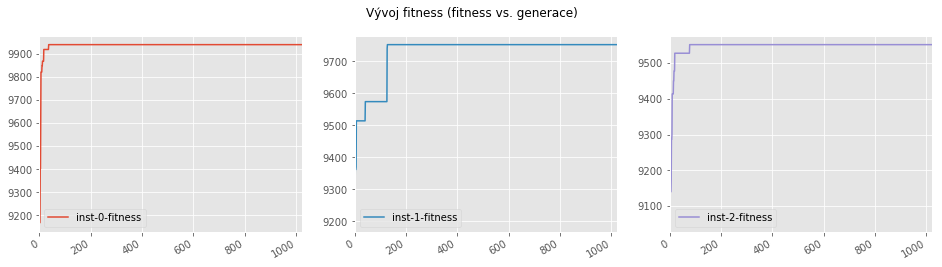

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from functools import reduce
from IPython.display import display, display_html

# Konfigurace vizualizace dat
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 4.0)
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 15

# Vizualizace
results = pd.read_csv('../data/out/results.csv')
data = reduce(lambda df1, df2: df1.join(df2), [
    pd.read_csv('../data/out/inspect-0.txt'),
    pd.read_csv('../data/out/inspect-1.txt'),
    pd.read_csv('../data/out/inspect-2.txt'),
])

data.plot(title = 'Vývoj fitness (fitness vs. generace)', subplots=True, layout=(1,3))
data.describe().transpose()[['min', 'mean', 'max']].transpose()

Na první spuštění to subjektivně není vůbec špatné. 

Prozkoumejme například instanci s ID 0 (45 klauzulí, 20 proměnných):  
Evoluce konvergovala po 37 generacích a dosáhla na hodnotu **9941**, což je dobrý výsledek, lze i předpokládat, že by mohlo jít o optimum. Koneckonců jde o jednodušší SAT problém.

Konvergence byla u všech instancí velmi rychlá a tak se v experimentální části pokusíme algoritmus "popostrčit", aby prohlédl i jiné části prohledáváného stavového prostoru.

In [193]:
results[:3]

,id,price,variables,clausules,satisfied,weight,valid
0,0,9941,20,45,45,925,True
1,1,9752,20,70,69,880,False
2,2,9552,20,91,89,785,False


S kvalitou řešení u složitějších problému to už tak pozitivní není. Pouze u první instance se podařilo nalézt validní řešení, druhá a třetí instance byla dokonalosti blízko, splněných klauzulí bylo 69 z 70, resp. 89 z 91. Od všech instancí by se ve výsledku očekávalo, že se je podaří vyřešit optimálně, jelikož jde stále o jednodušší problémy.

### Faktor náhodnosti

Následujícím měřením jen rychle ověříme, jak moc ovlivňuje výsledky náhoda. Všechny spuštěné instance jsou totožné a vycházejí z instance s ID 0.

,inst-3-fitness,inst-4-fitness,inst-5-fitness
min,9453.000000,9339.000000,9291.000000
mean,9937.400391,9926.743164,9934.000977
max,9941.000000,9941.000000,9941.000000


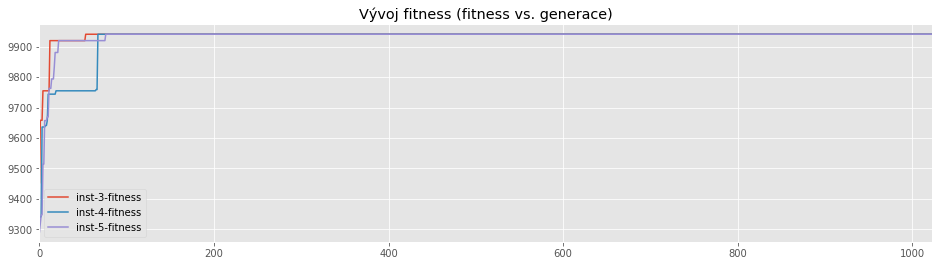

In [194]:
data = reduce(lambda df1, df2: df1.join(df2), list(map(lambda x: pd.read_csv('../data/out/inspect-'+str(x)+'.txt'), range(3,6))))

data.plot(title = 'Vývoj fitness (fitness vs. generace)')
data.describe().transpose()[['min', 'mean', 'max']].transpose()

Na grafu lze vidět, že může dojít k znatelné výchylce, ale nakonec grafy opisuje velmi navzájem podobný tvar a konvergence je tak velmi podobná.

Na data se lze spolehnout.

## Problémy

Z výsledků prvního řešení vzešly následující zjevné problémy:

 - Řešení rychle konverguje
 - Pro složitější problémy nedosahuje uspokojivých hodnot, vrací nevalidní řešení

## Experimentální řešení problémů

V této části se pokusíme vyřešit problémy, na které jsme narazili při základním spuštění, bez úpravy parametrů evoluce na vhodné hodnoty.

Experimenty spočívají v seřízení parametrů evoluce a pozorování zlepšení/zhoršení. Aby zpráva nebyla příliš dlouhá, budou experimenty popsány spíše slovně a grafem prezentována změna na jedné z instancí.

Měření bude prováděno na více instancích stejných vlastností, 20 proměnných a 91 klauzulí. Tato volba vychází z prvního měření, kde řešení nebylo úspěšné. Experimentem se tak pokusíme získat validní úspěšná řešení.

### Rychlá konvergence

Rychlou konvergenci k lokálnímu maximu lze vyřešit zvýšením pravděpodobnosti mutace, zvětšení velikosti turnaje a redukcí elitismu.

Experimentálně jsem upravoval parametry tímto směrem. Mutace sice může mít za následek zničení cenných potomků, ale zavede nás na jiná místa stavového prostoru. Navíc s takto strmou konvergencí si to do jisté míry můžeme dovolit.

Zvýšil jsem parametr pravděpodobnosti mutace z `0.1` na `0.4`, elitimus z dvou jedinců na jednoho, a nastavil velikost turnaje na `6`. Graf nyní vypadá jinak, konvergence není tak rychlá, mělo by docházet k širšímu prohledávání stavového prostoru.


,id,price,variables,clausules,satisfied,weight,valid
6,6,9620,20,91,90,600,False


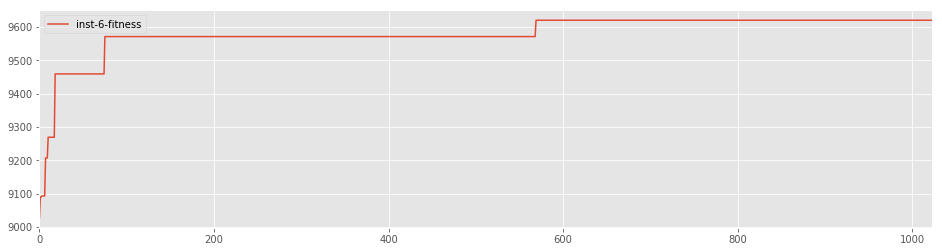

In [195]:
pd.read_csv('../data/out/inspect-6.txt').plot()
results[6:7]

### Zvýšení efektivity

Lehčí instance (45 klauzulí na 20 proměnných) počítáme úspěšně a pravděpodobně získáváme i optimální hodnotu. Těžší instance však stále vracejí nevalidní řešení.

Experimentem se pokoušíme dosáhnout co nejlepších řešení u těžších problémů.

Výsledky ovlivnila změna přítlaku na preferenci splněných klauzulí před váhovým ohodnocením. Zvýšil jsem koeficient *k* na hodnotu `0.9`, což se ukázalo jako přínosné. K zamyšlení však zůstává otázka, zda-li to nevede k sice platným, ale méně cenným řešením vzhledem k vahám.

Mírné doladění ostatních parametrů, jako zvětšení populace, úprava velikosti turnaje apod. vedly u různě obtížných instancí k různým následkům. Ponechal jsem tak ostatní parametry na stejných hodnotách, kromě zmíněného koeficientu *k* a kromě počtu generací pro obtížnější instance, který jsem zvýšil.

Pokusil jsem se experimentovat i s operátorem katastrofy, nicméně neúspěšně, situaci se mi podařilo jen zhoršit.


## Finální výsledky

Finální nastavení parametrů evoluce:

|Parametr | Hodnota |
|-|-|
|Velikost populace|48|
|Počet generací|2048|
|Pravděpodobnost křížení|0.9|
|Pravděpodobnost mutace|0.4|
|Velikost turnaje|8|
|Elitismus (jedinců)|1|

V grafech uvádím několik ukázkových instancí pro dané obtížnosti.

### Běžná obtížnost

U běžné obtížnosti se setkáváme s úspěchem, až na výjimky u středně těžších instancí, kdy nelze zaručit, že validní řešení existuje (data, která jsem používal takovou záruku nemají).



,inst-7-fitness,inst-8-fitness,inst-9-fitness,inst-10-fitness,inst-11-fitness,inst-12-fitness,inst-13-fitness,inst-14-fitness,inst-15-fitness
min,9455.000000,9458.000000,9448.000000,9352.000000,9131.000000,9092.000000,9028.000000,9236.00,9368.000000
mean,9882.018066,9853.480957,9791.955566,9661.187012,9592.256836,9710.359375,9638.444824,9690.75,9750.914551
max,9894.000000,9888.000000,9830.000000,9712.000000,9616.000000,9732.000000,9664.000000,9702.00,9769.000000


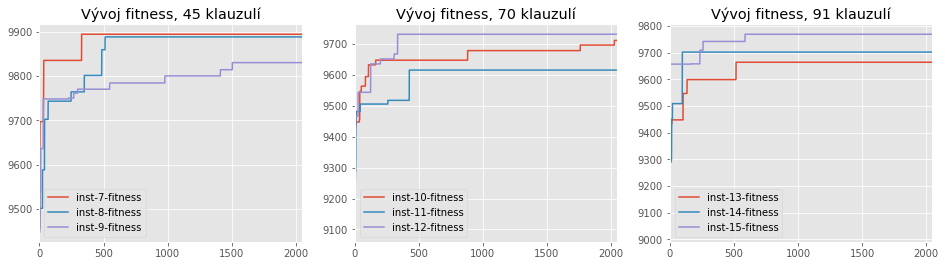

In [196]:
data1 = reduce(lambda df1, df2: df1.join(df2), list(map(lambda x: pd.read_csv('../data/out/inspect-'+str(x)+'.txt'), range(7,10))))
data2 = reduce(lambda df1, df2: df1.join(df2), list(map(lambda x: pd.read_csv('../data/out/inspect-'+str(x)+'.txt'), range(10,13))))
data3 = reduce(lambda df1, df2: df1.join(df2), list(map(lambda x: pd.read_csv('../data/out/inspect-'+str(x)+'.txt'), range(13,16))))

fig, axes = plt.subplots(nrows=1, ncols=3)
data1.plot(title = 'Vývoj fitness, 45 klauzulí', ax=axes[0])
data2.plot(title = 'Vývoj fitness, 70 klauzulí', ax=axes[1])
data3.plot(title = 'Vývoj fitness, 91 klauzulí', ax=axes[2])
reduce(lambda df1, df2: df1.join(df2), list(map(lambda x: pd.read_csv('../data/out/inspect-'+str(x)+'.txt'), range(7,16)))).describe().transpose()[['min', 'mean', 'max']].transpose()

In [197]:
results[7:16]

,id,price,variables,clausules,satisfied,weight,valid
7,7,9894,20,45,45,672,True
8,8,9888,20,45,45,857,True
9,9,9830,20,45,45,794,True
10,10,9712,20,70,70,618,True
11,11,9616,20,70,70,564,True
12,12,9732,20,70,70,691,True
13,13,9664,20,91,90,735,False
14,14,9702,20,91,90,683,False
15,15,9769,20,91,91,651,True


### Vysoká obtížnost

S plným úspěchem se nesetkáváme nikdy, nicméně úspěšnost měřím v procentech nalezených splněných klauzulí. Jsem si vědom, že tyto instance jsou vysoce náročné a neměl jsem ani očekávání, že bych svým algoritmem tyto instance úspěšně řešil.

**Průměrně bylo dosaženo `95.7%` nalezených splněných klauzulí** při 218 klauzulích na 50 proměnných (poměr 4.36, náročný).


,inst-16-fitness,inst-17-fitness,inst-18-fitness
min,8755.000000,8864.00000,8960.000000
mean,9251.212402,9191.07373,9235.240723
max,9268.000000,9219.00000,9254.000000


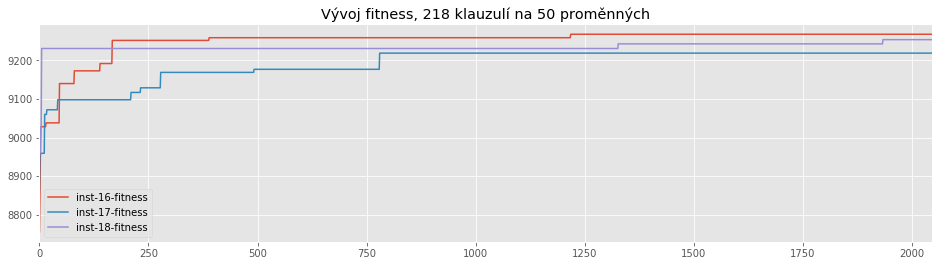

In [198]:
data = reduce(lambda df1, df2: df1.join(df2), list(map(lambda x: pd.read_csv('../data/out/inspect-'+str(x)+'.txt'), range(16,19))))
data.plot(title = 'Vývoj fitness, 218 klauzulí na 50 proměnných')
data.describe().transpose()[['min', 'mean', 'max']].transpose()

In [199]:
results[16:19]

,id,price,variables,clausules,satisfied,weight,valid
16,16,9268,50,218,208,1852,False
17,17,9219,50,218,207,1528,False
18,18,9254,50,218,211,1122,False



## Závěr

Bylo zajímavé sledovat, jak se stejný (resp. mírně upravený) genetický algoritmus choval pro značně lišící se problém od problému batohu.

Na SAT problému jsem si poprvé vyzkoušel práci s přísnými omezujícími podmínkami a přetržitým stavovým prostorem, zkušenost považuji za pozitivní a subjektivně velmi vítanou.

S počtem nalezených klauzulí držící se nad hranicí 90% u těžkých instancí jsem spokojen a výsledek předčil má očekávání.

Zdrojové soubory úlohy lze najít na GitHubu. Link je uveden v hlavičce zprávy.